In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<ipython-input-2-e2d91ad21a0c>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-2-e2d91ad21a0c>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


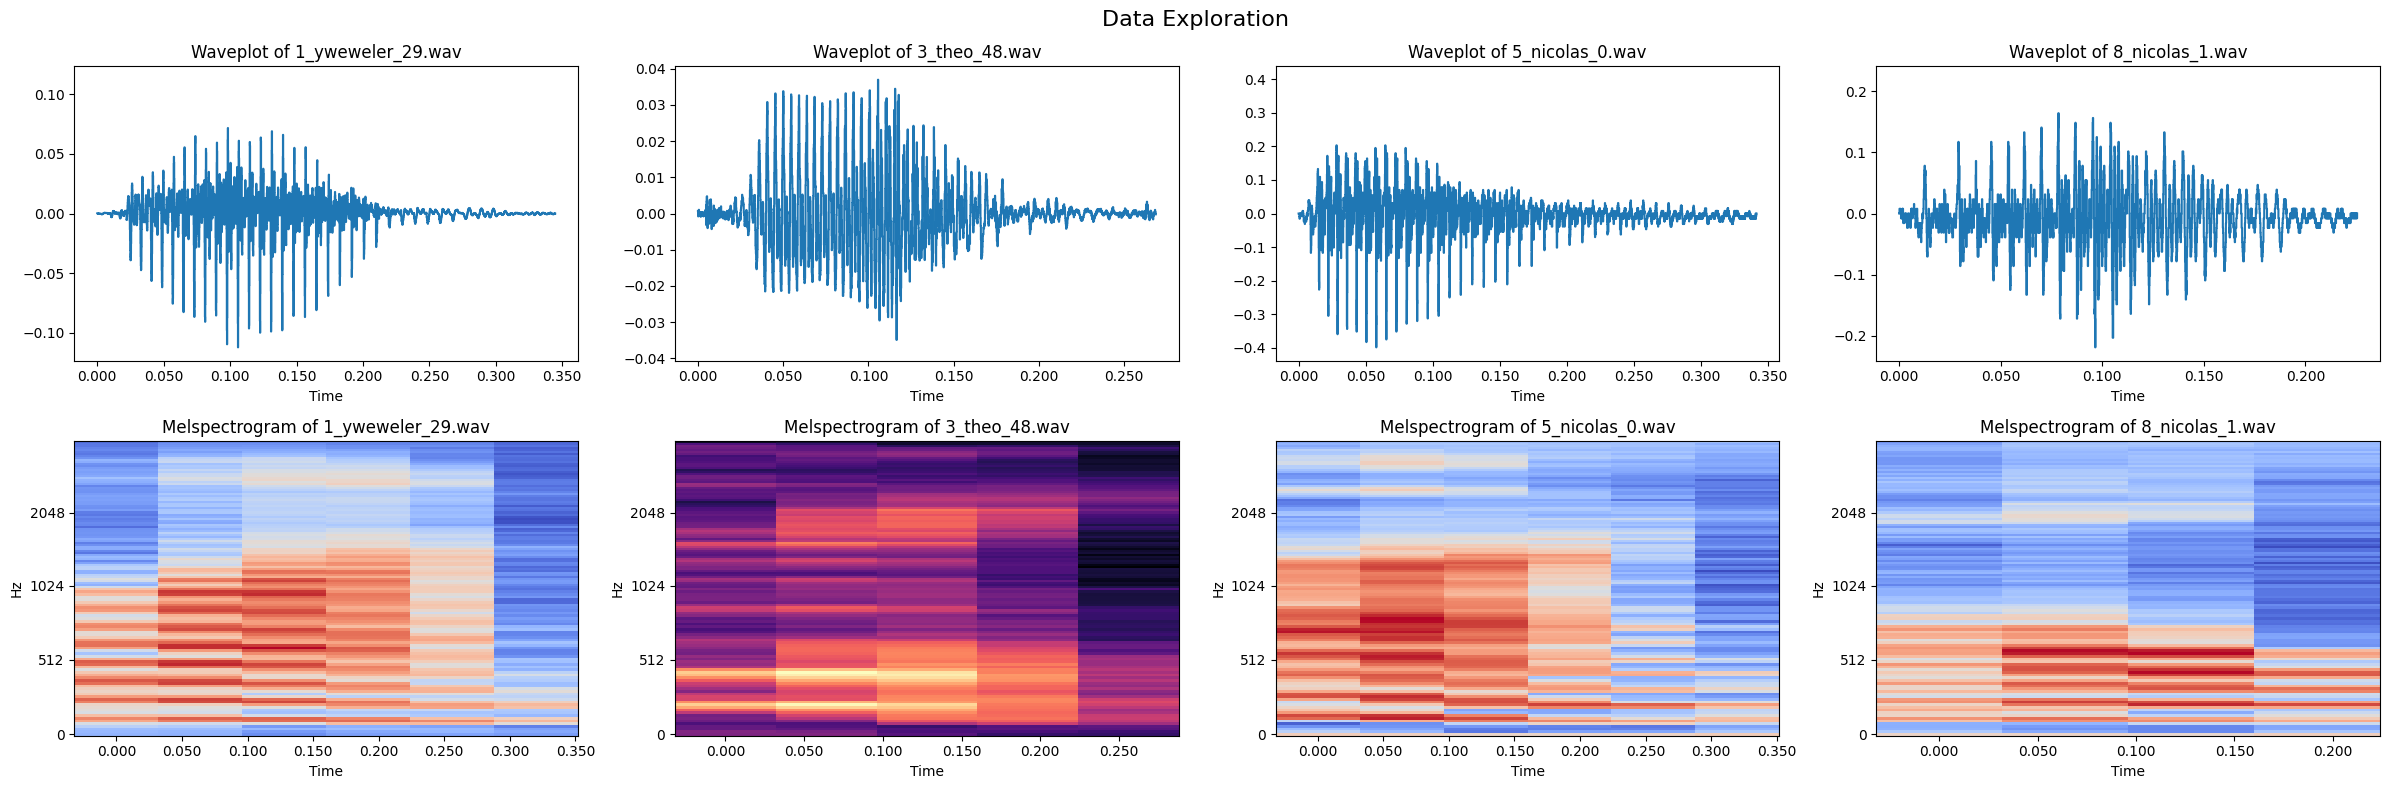

In [ ]:
visualize_digits = [1, 3, 5, 8]

description = pd.read_csv('/content/drive/MyDrive/PROJECT/rec/train.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)
for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_digits)])
    axs[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [ ]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/PROJECT/rec/recordings')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 3020/3020 [02:21<00:00, 21.39it/s]


In [ ]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Assuming features have shape (128, 16, 1) based on your previous code
input_shape = features[0].shape

model_rnn_lstm = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    keras.layers.Reshape((input_shape[0], -1)),  # Flatten the last dimension
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

model_rnn_lstm.compile(optimizer=keras.optimizers.Adam(),
                       loss=keras.losses.categorical_crossentropy,
                       metrics=['accuracy'])

print(model_rnn_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 128, 16)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 32)           6272      
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 31754 (124.04 KB)
Trainable params: 31754 (124.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/10
24/24 [==============================] - 14s 364ms/step - loss: 2.2559 - accuracy: 0.1684 - val_loss: 2.1633 - val_accuracy: 0.2252
Epoch 2/10
24/24 [==============================] - 4s 161ms/step - loss: 2.0475 - accuracy: 0.2792 - val_loss: 1.9925 - val_accuracy: 0.2677
Epoch 3/10
24/24 [==============================] - 5s 218ms/step - loss: 1.8552 - accuracy: 0.3374 - val_loss: 1.8954 - val_accuracy: 0.3323
Epoch 4/10
24/24 [==============================] - 6s 230ms/step - loss: 1.7366 - accuracy: 0.4165 - val_loss: 1.7692 - val_accuracy: 0.3874
Epoch 5/10
24/24 [==============================] - 4s 160ms/step - loss: 1.6782 - accuracy: 0.4239 - val_loss: 1.6041 - val_accuracy: 0.4598
Epoch 6/10
24/24 [==============================] - 4s 152ms/step - loss: 1.5092 - accuracy: 0.5057 - val_loss: 1.5040 - val_accuracy: 0.4976
Epoch 7/10
24/24 [==============================] - 6s 251ms/step - loss: 1.3966 - accuracy: 0.5382 - val_loss: 1.3442 - val_accuracy: 0.5669
Epoch

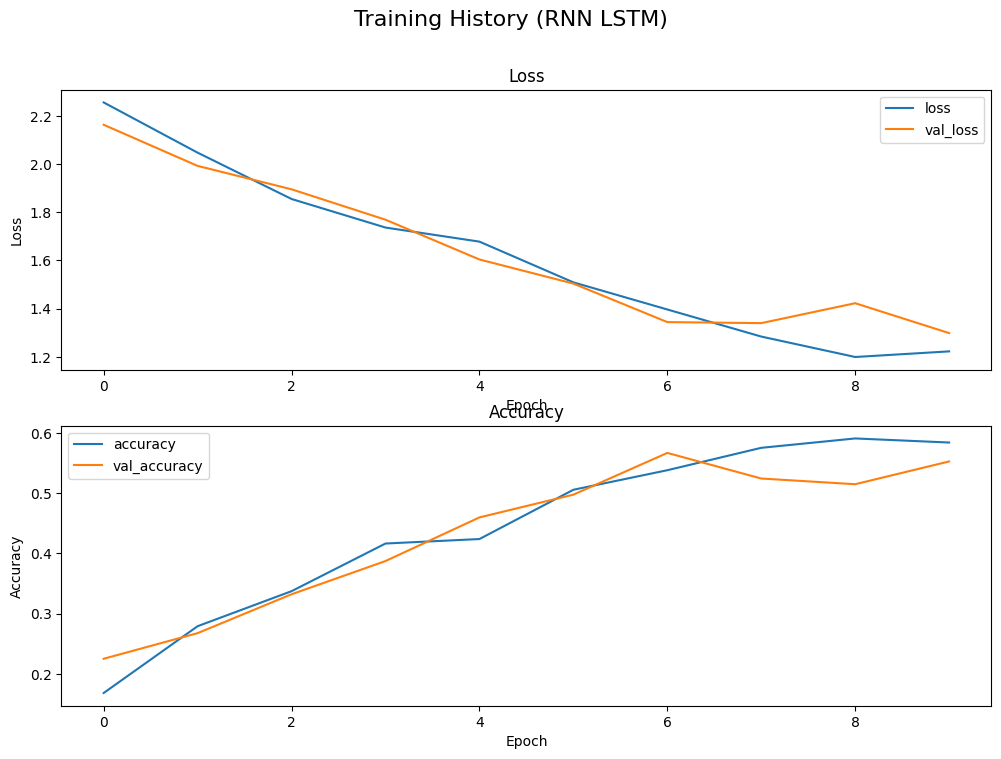

In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 10

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the RNN LSTM model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_rnn_lstm = model_rnn_lstm.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History (RNN LSTM)', fontsize=16)
axs[0].plot(history_rnn_lstm.epoch, history_rnn_lstm.history['loss'], history_rnn_lstm.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history_rnn_lstm.epoch, history_rnn_lstm.history['accuracy'], history_rnn_lstm.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

29/29 [==============================] - 2s 30ms/step


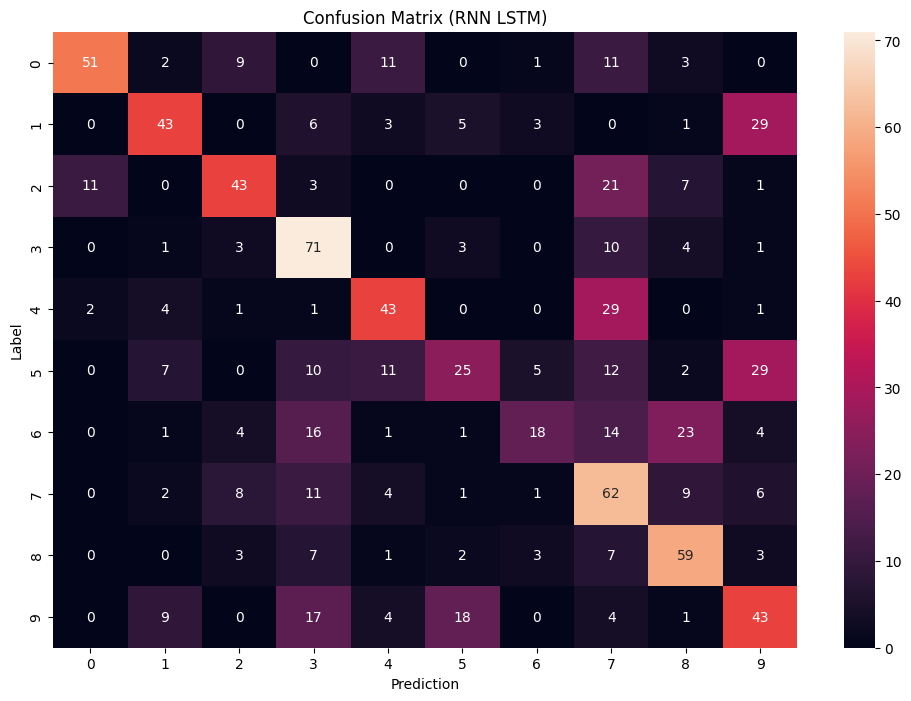

In [ ]:
# Evaluate the RNN LSTM model
y_predicted_rnn_lstm = np.argmax(model_rnn_lstm.predict(x=X_test), axis=1)
label_names_rnn_lstm = np.unique(labels)
confusion_matrix_rnn_lstm = tf.math.confusion_matrix(labels=np.argmax(y_test, axis=1), predictions=y_predicted_rnn_lstm)
fig_rnn_lstm = plt.figure()
fig_rnn_lstm.set_size_inches(12, 8)
sns.heatmap(confusion_matrix_rnn_lstm, xticklabels=label_names_rnn_lstm, yticklabels=label_names_rnn_lstm, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix (RNN LSTM)')
plt.show()